In [1]:
import phoebe
import numpy as np
from spice.models.phoebe_model import PhoebeModel
from spice.spectrum import simulate_spectrum
from transformer_payne import Blackbody
import matplotlib
%matplotlib inline

from phoebe.parameters.dataset import _mesh_columns

PHOEBE: passband "Bolometric:900-40000" has a newer version available.  Run phoebe.list_passband_online_history("Bolometric:900-40000") to get a list of available changes and phoebe.update_passband("Bolometric:900-40000") or phoebe.update_all_passbands() to update.
PHOEBE: passband "Johnson:V" has a newer version available.  Run phoebe.list_passband_online_history("Johnson:V") to get a list of available changes and phoebe.update_passband("Johnson:V") or phoebe.update_all_passbands() to update.


# Using PHOEBE models

You can refer to the [PHOEBE](http://phoebe-project.org) documentation to learn how to use this software.

The basic prerequisites are a model which contains a mesh dataset with:
- uvw coordinates
- all the mesh columns

In [2]:
b = phoebe.default_star()
b.set_quantity('incl', 90)
b.set_quantity('period', 2)
times = np.linspace(0, 1, 10)
COLUMNS = _mesh_columns

b.add_dataset('mesh', compute_times=times, columns=COLUMNS, dataset='mesh01')
b.run_compute(irrad_method='none', coordinates='uvw')

100%|██████████| 10/10 [00:00<00:00, 174.24it/s]


<ParameterSet: 312 parameters | qualifiers: vxs, xyz_elements, areas, loggs, volume, vys, visibilities, vs, nus, teffs, comments, rs, times, ws, nvs, rprojs, uvw_normals, vzs, nxs, vws, uvw_elements, visible_centroids, xs, zs, nzs, vus, nws, us, nys, vvs, mus, ys, xyz_normals>

To create a SPICE model, create a ```PhoebeConfig``` object first. This will contain the ```PHOEBE``` model and some utility functions. You have to pass in the name of the mesh dataset that will be used.

In [3]:
from spice.models.phoebe_utils import PhoebeConfig
p = PhoebeConfig(b, 'mesh01')

Then, a ```PhoebeModel``` can be constructed for the ```PhoebeConfig``` model and selected timestamp.

```PhoebeConfig``` contains the information about all timesteps, and the ```PhoebeModel``` is created for one timestep only.

In [4]:
bb = Blackbody()
pm = PhoebeModel.construct(p, times[0], bb.parameter_names)
pm2 = PhoebeModel.construct(p, times[5], bb.parameter_names)

After creating a ```PhoebeModel```, a spectrum can be synthesized the same way as for a regular ```Icosphere``` model.

In [5]:
ws = np.linspace(4000, 10000, 1000)
s = simulate_spectrum(bb.intensity, pm, np.log10(ws))

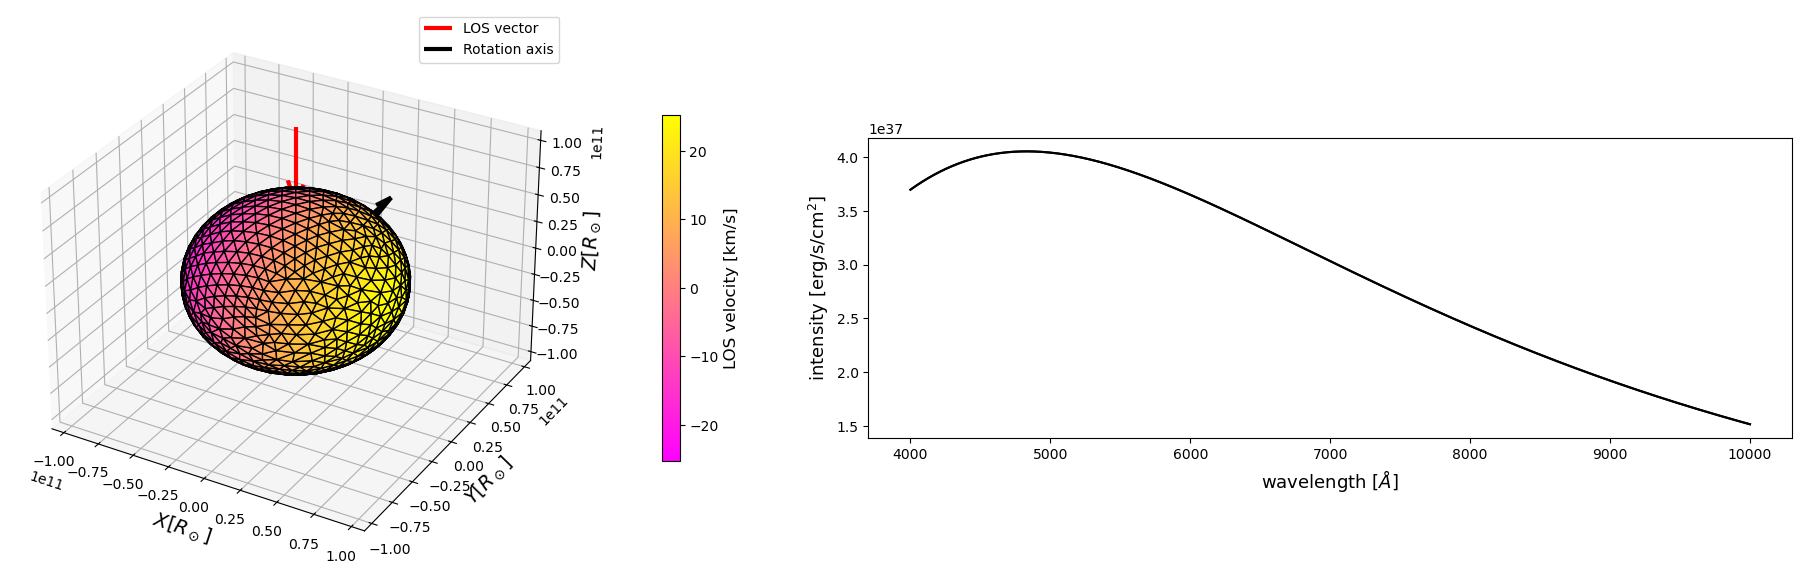

In [6]:
from spice.plots import plot_3D_mesh_and_spectrum

_, _, _ = plot_3D_mesh_and_spectrum(pm, wavelengths=ws, spectrum=s, mesh_plot_kwargs=dict(property='los_velocities', cmap='spring'))

In [13]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import art3d

fig = plt.figure(figsize=(10, 12))
spec = fig.add_gridspec(10, 12)
plot_ax = fig.add_subplot(spec[:, :11], projection='3d')
plot_ax.view_init(elev=30, azim=60)
axes_lim = 1.5*pm.radius
plot_ax.set_xlim3d(-axes_lim, axes_lim)
plot_ax.set_ylim3d(-axes_lim, axes_lim)
plot_ax.set_zlim3d(-axes_lim, axes_lim)
plot_ax.set_xlabel('$X [R_\\odot]$', fontsize=14)
plot_ax.set_ylabel('$Y [R_\\odot]$', fontsize=14)
plot_ax.set_zlabel('$Z [R_\\odot]$', fontsize=14)
normalized_los_vector = pm.los_vector/np.linalg.norm(pm.los_vector)
normalized_rotation_axis = pm.rotation_axis/np.linalg.norm(pm.rotation_axis)
mesh=pm
plot_ax.quiver(*(-2.0*mesh.radius*normalized_los_vector), *(mesh.radius*normalized_los_vector),
                   color='red', linewidth=3., label='LOS vector')
plot_ax.quiver(*(0.75*mesh.radius*normalized_rotation_axis), *(mesh.radius*normalized_rotation_axis),
                color='black', linewidth=3., label='Rotation axis')
plot_ax.legend()
vs2 = mesh.cast_vertices
to_be_mapped = pm.los_velocities
norm = mpl.colors.Normalize(vmin=to_be_mapped.min(), vmax=to_be_mapped.max())
mappable = mpl.cm.ScalarMappable(cmap='spring', norm=norm)
face_colors = mpl.colormaps['spring'](norm(to_be_mapped))
c = pm.centers
v = pm.center_velocities
for cc, vv in zip(c, v):
    plot_ax.quiver(*(cc), *(0.04*mesh.radius*vv), alpha=0.3)
p = art3d.Poly3DCollection(vs2, facecolors=face_colors, edgecolor="black")
plot_ax.add_collection(p)
mappable.set_array([])
cbar = fig.colorbar(mappable, shrink=0.45, pad=0.125, ax=plot_ax)

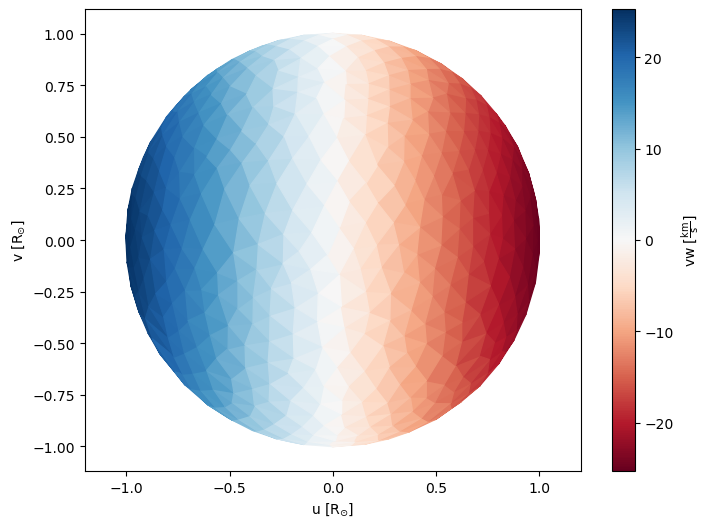

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 800x600 with 2 Axes>)

In [11]:
b.plot(dataset='mesh01', time=0.0, fc='vws', ec='face', show=True, colorbar=True, draw_sidebars=True)